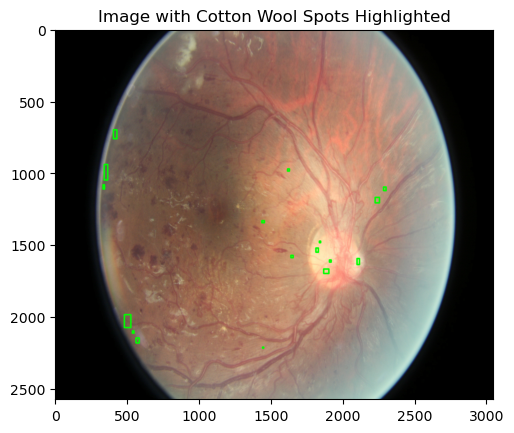

Number of Cotton Wool Spots: 21
Resulting image with boxes saved at: cws_detected_image.png


In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters.rank import entropy

def count_cotton_wool_spots(image_path):
    # Read the image
    img = Image.open(image_path)
    img = img.resize((3046, 2572))

    # Extract red and green channels
    image_array = np.array(img)
    green = image_array[:, :, 1]

    # Apply image processing steps
    erosion_kernel = np.ones((80, 80), np.uint8)
    eroded_green = cv2.erode(green, erosion_kernel, iterations=1)
    median = cv2.medianBlur(eroded_green, 15)
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(41, 41))
    closing = cv2.morphologyEx(median, cv2.MORPH_CLOSE, kernel)

    gamma = 2
    gamma_corrected = np.array(np.max(closing) * (closing / np.max(closing)) ** gamma, dtype='uint8')

    # Calculate entropy using the circular mask
    def calculate_entropy_circular(image, radius):
        mask = np.zeros_like(image, dtype=np.uint8)
        y, x = np.ogrid[:image.shape[0], :image.shape[1]]
        mask[(x - image.shape[1] // 2)**2 + (y - image.shape[0] // 2)**2 <= radius**2] = 1

        entropy_image = entropy(image, mask)
        return entropy_image

    radius = 8
    gamma_corrected_uint8 = (gamma_corrected * 255).astype(np.uint8)
    entropy_circular = calculate_entropy_circular(gamma_corrected_uint8, radius)

    scaled_entropy = (entropy_circular - np.min(entropy_circular)) / (np.max(entropy_circular) - np.min(entropy_circular))
    bw = np.array(scaled_entropy > 0.6, dtype=np.uint8)
    bw = cv2.medianBlur(bw, 15)

    kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(41, 41))
    bw_closing = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

    bw_contours, _ = cv2.findContours(bw_closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a copy of the original image to draw squares on
    image_with_squares = image_array.copy()

    # Define minimum and maximum area thresholds for bounding boxes
    max_area_threshold = 90000

    for contour in bw_contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        if area < max_area_threshold:
            cv2.rectangle(image_with_squares, (x, y), (x+w, y+h), (0, 255, 0), 9)

    # Display the image with squares
    plt.imshow(image_with_squares)
    plt.title('Image with Cotton Wool Spots Highlighted')
    plt.show()

    # Save the image with squares
    output_path = 'cws_detected_image.png'
    cv2.imwrite(output_path, cv2.cvtColor(image_with_squares, cv2.COLOR_RGB2BGR))

    return len(bw_contours), output_path

# Example usage:
image_file_path = "16_left.jpeg"
num_cws, output_image_path = count_cotton_wool_spots(image_file_path)
print(f'Number of Cotton Wool Spots: {num_cws}')
print(f'Resulting image with boxes saved at: {output_image_path}')
